In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, average_precision_score
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### DFDC Dataset Download

In [47]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("aleksandrpikul222/dfdcdfdc")
directory = "/Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/"

In [61]:
files = ["TEST_CLIENT.txt", "TRAIN_CLIENT.txt", "TRAIN_IMPOSTER.txt", "TEST_IMPOSTER.txt", "VAL_CLIENT.txt", "VAL_IMPOSTER.txt"]
#old_path = "/kaggle/input/dfdcdfdc/DFDCDFDC/DFDCDFDC"
old_path = "/Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3"
new_path = "/Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/DFDCDFDC/DFDCDFDC/"

In [62]:
for file in files:
    path = os.path.join(directory, file) 
    with open(path, "r") as f:
        lines = f.readlines()
    
    with open(path, "w") as f:
        for line in lines:
            new_line = line.replace(old_path, new_path)
            f.write(new_line)

    print(f"Updated {file} with new path: {new_path}")

print("All files updated successfully!")

Updated TEST_CLIENT.txt with new path: /Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/DFDCDFDC/DFDCDFDC/
Updated TRAIN_CLIENT.txt with new path: /Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/DFDCDFDC/DFDCDFDC/
Updated TRAIN_IMPOSTER.txt with new path: /Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/DFDCDFDC/DFDCDFDC/
Updated TEST_IMPOSTER.txt with new path: /Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/DFDCDFDC/DFDCDFDC/
Updated VAL_CLIENT.txt with new path: /Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/DFDCDFDC/DFDCDFDC/
Updated VAL_IMPOSTER.txt with new path: /Users/isitthakkar/.cache/kagglehub/datasets/aleksandrpikul222/dfdcdfdc/versions/3/DFDCDFDC/DFDCDFDC/
All files updated successfully!


### Data Loading

In [63]:
class ASDataset(Dataset):
    def __init__(self, client_file: str, imposter_file: str, transforms=None):
        with open(client_file, "r") as f:
            client_files = f.read().splitlines()
        with open(imposter_file, "r") as f:
            imposter_files = f.read().splitlines()
        self.labels = torch.cat((torch.ones(len(client_files)), torch.zeros(len(imposter_files))))
        self.imgs = client_files + imposter_files
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img = Image.open(img_name)
        label = self.labels[idx]
        if self.transforms:
            img = self.transforms(img)
        return img, label

### Data Pre-processing

In [64]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Splitting the data into train and test sets

In [65]:
train_dataset = ASDataset(client_file=directory + "TRAIN_CLIENT.txt", imposter_file=directory +"TRAIN_IMPOSTER.txt", transforms=preprocess)
test_dataset = ASDataset(client_file=directory +"TEST_CLIENT.txt", imposter_file=directory +"TEST_IMPOSTER.txt", transforms=preprocess)
val_dataset = ASDataset(client_file=directory+"VAL_CLIENT.txt", imposter_file=directory +"VAL_IMPOSTER.txt", transforms=preprocess)

In [66]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [67]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

80000
9946
10054


### Model Built

In [68]:
from VisionKAN import create_model, train_one_epoch, evaluate
device = torch.device("mps")

KAN = create_model(
    model_name='deit_tiny_patch16_224_KAN',
    pretrained=False,
    hdim_kan=192,
    num_classes=1,
    drop_rate=0.0,
    drop_path_rate=0.05,
    img_size=224,
    batch_size=32
)

# VisionLSTM model
vision_lstm = torch.hub.load("nx-ai/vision-lstm", "VisionLSTM", 
    dim=192,  
    depth=24,  
    patch_size=16,
    input_shape=(3, 224, 224),  
    output_shape=(1,),  
    drop_path_rate=0.05,  
    stride=None 
)

{'hdim_kan': 192, 'num_classes': 1, 'drop_rate': 0.0, 'drop_path_rate': 0.05, 'img_size': 224, 'batch_size': 32}


Using cache found in /Users/isitthakkar/.cache/torch/hub/nx-ai_vision-lstm_main


In [69]:
# Custom Model combining ViT and VisionLSTM
class CombinedModel(nn.Module):
    def __init__(self, KAN, vision_lstm):
        super(CombinedModel, self).__init__()
        self.KAN = KAN
        self.vision_lstm = vision_lstm
        self.fc1 = nn.Linear(2, 512)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        KAN_output = self.KAN(x)
        lstm_output = self.vision_lstm(x)
        combined = torch.cat((KAN_output, lstm_output), dim=1)
        x = self.fc1(combined)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CombinedModel(KAN, vision_lstm).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.45)
num_epochs = 10

train_loss_history = []
train_accuracy_history = []

In [70]:
from tqdm import tqdm
from collections import OrderedDict

def get_accuracy(preds, labels):
    return torch.sum((preds.flatten() > 0.5) == labels.to(device)) / labels.numel()

def train(epoch):
    running_loss = 0.0 
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader))):
        pbar.set_postfix(**msg)
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(
            outputs, labels.unsqueeze(-1).to(device)
        )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += get_accuracy(outputs, labels.to(device))
        if not i % 10 and i > 0:
            msg.update({"train_epoch": epoch + 1, "loss": running_loss / i, "acc": (running_acc / i).item()})
            pbar.set_postfix(**msg)

def validate():
    val_loss = 0.0  
    val_acc = 0.0
    model.eval()
    for i, (inputs, labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(device))
        loss = criterion(
            outputs, labels.unsqueeze(-1).to(device)  # Считаем loss
        )
        val_loss += loss.item()
        val_acc += get_accuracy(outputs, labels.to(device))
    val_loss /= len(test_loader)
    val_acc /= len(test_loader)
    scheduler.step()
    msg.update({"val_loss": val_loss, "val_acc": val_acc.item()})  
    print(f"val_loss: {val_loss}, val_acc: {val_acc.item()}")
    return val_acc.item()   
      
msg = OrderedDict({"train_epoch": None, "loss": None, "acc": None, \
                "val_loss": None, "val_acc": None})

In [71]:
model.to(device)
max_val_acc = 0 
for epoch in range(num_epochs):   
    optimizer.zero_grad()                    
    train(epoch)                                     
    val_acc = validate()                                                   
    if val_acc > max_val_acc:                         
        max_val_acc = val_acc 
        torch.save(model.state_dict(), f"as_model_{val_acc:.3f}.pt")  

100%|██████████| 2500/2500 [1:14:02<00:00,  1.78s/it, acc=0.811, loss=0.548, train_epoch=1, val_acc=None, val_loss=None]


val_loss: 0.49314947670679, val_acc: 0.9557877779006958


100%|██████████| 2500/2500 [4:10:33<00:00,  6.01s/it, acc=0.879, loss=0.517, train_epoch=2, val_acc=0.956, val_loss=0.493]    


val_loss: 0.4864166192111478, val_acc: 0.9654340744018555


100%|██████████| 2500/2500 [6:06:39<00:00,  8.80s/it, acc=0.891, loss=0.512, train_epoch=3, val_acc=0.965, val_loss=0.486]     


val_loss: 0.48692937765474104, val_acc: 0.9658359885215759


100%|██████████| 2500/2500 [1:12:58<00:00,  1.75s/it, acc=0.898, loss=0.509, train_epoch=4, val_acc=0.966, val_loss=0.487]


val_loss: 0.4919893730108378, val_acc: 0.9579983949661255


100%|██████████| 2500/2500 [2:56:39<00:00,  4.24s/it, acc=0.902, loss=0.508, train_epoch=5, val_acc=0.958, val_loss=0.492]     


val_loss: 0.4907587168684343, val_acc: 0.959304690361023


100%|██████████| 2500/2500 [1:13:31<00:00,  1.76s/it, acc=0.903, loss=0.507, train_epoch=6, val_acc=0.959, val_loss=0.491]


val_loss: 0.49073814195835325, val_acc: 0.959304690361023


100%|██████████| 2500/2500 [1:13:57<00:00,  1.77s/it, acc=0.904, loss=0.506, train_epoch=7, val_acc=0.959, val_loss=0.491]


val_loss: 0.49144870483606956, val_acc: 0.9579983949661255


100%|██████████| 2500/2500 [1:14:02<00:00,  1.78s/it, acc=0.904, loss=0.506, train_epoch=8, val_acc=0.958, val_loss=0.491]


val_loss: 0.4905616170532067, val_acc: 0.9598070979118347


100%|██████████| 2500/2500 [1:13:50<00:00,  1.77s/it, acc=0.904, loss=0.506, train_epoch=9, val_acc=0.96, val_loss=0.491]


val_loss: 0.49170864347092974, val_acc: 0.9578979015350342


100%|██████████| 2500/2500 [1:14:03<00:00,  1.78s/it, acc=0.904, loss=0.506, train_epoch=10, val_acc=0.958, val_loss=0.492]


val_loss: 0.49177429779549503, val_acc: 0.9580988883972168


In [72]:
outputs = []
y_true = []
for i, (inputs, labels) in enumerate(test_loader):
    with torch.no_grad():
        outputs.append(model(inputs.to(device)).flatten().cpu().numpy())
        y_true.append(labels.numpy())
preds = (np.concatenate(outputs) > 0.5).astype(int)
outputs = np.concatenate(outputs)
y_true = np.concatenate(y_true)

In [73]:
from sklearn.metrics import roc_auc_score

model.load_state_dict(torch.load("as_model_0.965.pt", map_location=torch.device('mps')))
model.eval()

CombinedModel(
  (KAN): VisionKAN(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): kanBlock(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
      

APCER 0.08716165880307922
BPCER 0.011150532184490624
ACER 0.04915609549378492
FRR 0.011150532184490624
FAR 0.08716165880307922
HTER 0.04915609549378492
ROC AUC score: 0.984855918277258
EER: 0.045691581822696795
F1 score: 0.965602573620391
Precision score: 0.9434235976789168
Recall score: 0.9888494678155094


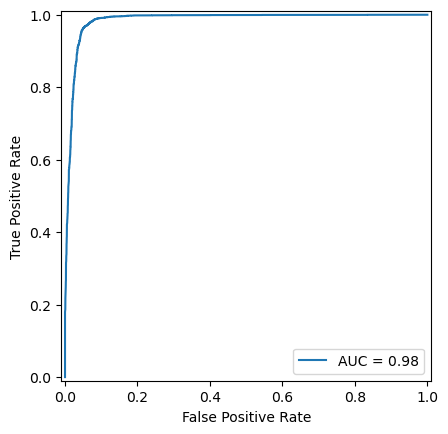

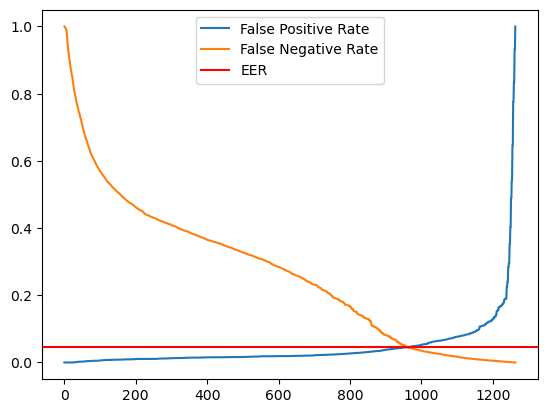

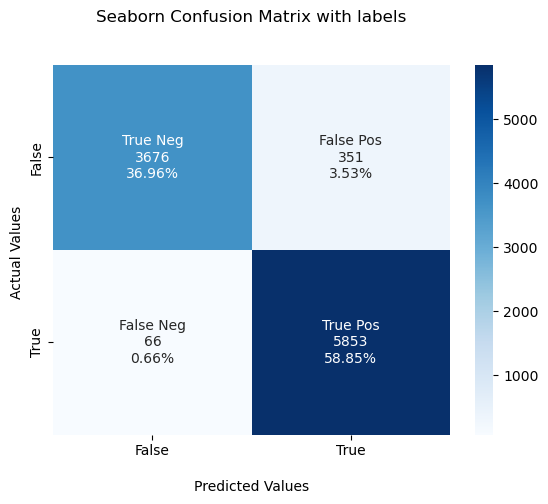

In [74]:
from sklearn.metrics import roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt


tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

apcer = fp/(tn + fp)
bpcer = fn/(fn + tp)
acer = (apcer + bpcer) / 2.0
frr = fn/(fn + tp)
far = fp/(fp + tn)
hter = (frr + far) / 2.0

print('APCER', apcer)
print('BPCER', bpcer)
print('ACER', acer)
print('FRR', frr)
print('FAR', far)
print('HTER', hter)

fpr, tpr, threshold = roc_curve(y_true, outputs, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("ROC AUC score:", roc_auc_score(y_true, outputs))
print("EER:", EER)
print("F1 score:", metrics.f1_score(y_true, preds))
print("Precision score:", metrics.precision_score(y_true, preds))
print("Recall score:", metrics.recall_score(y_true, preds))

fpr, tpr, thresholds = metrics.roc_curve(y_true, outputs)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
display.plot()
plt.show()
plt.plot(fpr, label="False Positive Rate")
fnr = 1 - tpr
plt.plot(fnr, label="False Negative Rate")
plt.axhline(y=EER, label="EER", color='r', linestyle='-')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(y_true, preds)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
 
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')   
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()